<a href="https://colab.research.google.com/github/heejeongJ/DL_pt/blob/Convolutional-Neural-Network_CNN/CNN_2021111408_%EC%A3%BC%ED%9D%AC%EC%A0%95(%EC%A0%9C%EC%B6%9C%EB%B2%84%EC%A0%84).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **사용할 라이브러리 설정**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

# 파이토치에서는 torchvision.datasets에 MNIST 등의 다양한 데이터를 사용하기 용이하게 정리해 놓음
# 이를 사용하면 데이터를 따로 학습에 맞게 정리하거나 하지 않아도 바로 사용이 가능함
import torchvision.datasets as dset

# torchvision.transforms에서는 이미지 데이터를 자르거나 확대 및 다양하게 변형시키는 함수들이 구현되어 있음
import torchvision.transforms as transforms
# DataLoader는 전처리가 끝난 데이터들을 지정한 배치 크기에 맞게 모아서 전달해주는 역할을 함
# 데이터를 불러온 다음에 전처리 수행하고 불러온 이미지를 네트워크에 한 번에 올려주기 위해 사용
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)

2.1.0+cu118


# **하이퍼파라미터 설정**

In [ ]:
batch_size = 256        # 배치 사이즈
learning_rate = 0.0002  # 학습률
num_epoch = 10

# **데이터셋 로딩 및 텐서 변환**

In [ ]:
# 첫번째 인자 root는 데이터를 저장할 위치, train은 학습용 데이터인지 테스트용 데이터인지의 여부를 의미함

# MNIST 데이터는 숫자 손글씨 이미지와 이에 대한 정답 쌍으로 이루어져 있음
# trainform은 이미지에 대한 변형,target_transform은 정답 라벨에 대한 변형을 의미함
# trainform.ToTensor()는 PIL 이미지나 Numpy 배열을 토치 텐서로 바꿔줌
mnist_train = dset.MNIST(root="../", train=True, transform = transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST(root="../", train=False, transform = transforms.ToTensor(), target_transform=None, download=True)

**데이터셋 체크**

In [ ]:
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

print(len(mnist_train), len(mnist_test))

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000
60000 10000


# **데이터 로더(DataLoader) 설정**

In [ ]:
train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle = True, num_workers=2, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size = batch_size, shuffle = False, num_workers=2, drop_last=True)

# **CNN 모델**

In [ ]:
class CNN(nn.Module):
  def __init__(self):                              ## 초기화 메서드 (이 메서드 내에서 드롭아웃해야 하는 듯..?)
    super(CNN, self).__init__()                                     # 상위 클래스(nn.Module)의 초기화 메서드 호출
    self.layer = nn.Sequential(                                     # 신경망의 convolutional layer 부분 정의
        nn.Conv2d(in_channels = 1, out_channels=32, kernel_size=3, padding=1), # 2D convolution layer (이미지에서 특징을 추출하는 데 사용됨), 패딩 적용해서 사이즈 변화되지 않도록 했음~!
        nn.ReLU(),                                                  # 활성화 함수 (모델이 복잡한 패턴 학습할 수 있게 도움)
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)                       # Max Pooling layer (특징 맵의 크기를 줄이면서 중요한 정보는 보존하는 데 사용)
    )
    self.fc_layer = nn.Sequential(                                  # Fully connected layer 부분 정의
        nn.Linear(64*7*7, 256),                                     # FC Layer 1      - 선형 레이어, 입력과 가중치를 곱하고 편향을 더해 출력을 생성
        nn.ReLU(),
        nn.Dropout(0.8),                                            # Dropout (dropout rate 0.8)
        nn.Linear(256, 256),                                        # FC Layer 2
        nn.ReLU(),
        nn.Dropout(0.8),                                            # Dropout (dropout rate 0.8)
        nn.Linear(256, 10)                                          # 얜 출력층 레이어~!
    )

  def forward(self,x):                                              # 순전파 메서드 (모델이 입력 데이터를 어떻게 처리할지 정의)
    out = self.layer(x)
    out= out.view(out.size(0), -1)                                   # 틀징 맵 평탄화(flatten). -1은 나머지 차원을 자동으로 계산하도록 함

    out = self.fc_layer(out)                                        # 평탄화된 데이터를 전결합 레이어에 전달하여 최종 결과를 얻음
    return out


# **GPU 사용 가능 여부 확인 및 설정(모델 학습 준비)**
**- 손실 함수, 최적화 함수**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN().to(device)

loss_func = nn.CrossEntropyLoss()                                   # 손실 함수 정의 - CrossEntropy 적용

optimizer_Adam = torch.optim.Adam(model.parameters(), lr=learning_rate)  # 옵티마이저 정의 - AdamOptimizer 사용
# optimizer_SGD = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)     # 옵티마이저 정의 - SGDOptimizer 사용 , 모멘텀을 통해과거의 그라디언트가 현재의 업데이트에 영향 미치도록 함, 안정적 학습 가능하도록 설정
# scheduler = optim.lr_scheduler.StepLR(optimizer_SGD, step_size=20, gamma=0.4)           # 학습률 스케줄러 설정

cuda:0


# **모델 학습 with Adam**

In [ ]:
loss_arr_Adam = []
for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader) :
    x=image.to(device)
    y_=label.to(device)

    optimizer_Adam.zero_grad()
    output = model.forward(x)
    loss = loss_func(output, y_)
    loss.backward()
    optimizer_Adam.step()

    if j%1000 == 0:
      print(loss)
      loss_arr_Adam.append(loss.cpu().detach().numpy())

tensor(2.3063, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0055, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6507, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5749, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3731, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2801, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2369, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2478, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1986, device='cuda:0', grad_fn=<NllLossBackward0>)


# **학습 결과 시각화_ 손실 변화 그래프 with Adam**

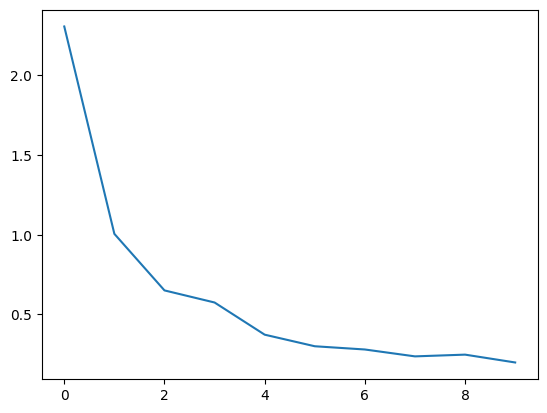

In [ ]:
plt.plot(loss_arr_Adam)
plt.show()

# **테스트 데이터셋을 통한 성능 평가**
# **Adam 옵티마이저로 학습한 모델의 정확도 측정**

In [ ]:
# 정확도 계산 함수
def calculate_accuracy(model, device, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for image, label in test_loader:
            x = image.to(device)
            y_ = label.to(device)
            output = model(x)
            _, predicted = torch.max(output, 1)
            total += label.size(0)
            correct += (predicted == y_).sum().item()
    accuracy = 100 * correct / total
    return accuracy


# Adam 옵티마이저로 학습된 모델의 정확도 측정
accuracy_adam = calculate_accuracy(model, device, test_loader)
print(f"Accuracy with Adam: {accuracy_adam}%")


Accuracy with Adam: 92.66826923076923%


# **모델 학습 with SGD**

In [ ]:
# 모델을 다시 초기화하고 SGD 옵티마이저로 학습하기 위함
model = CNN().to(device)  # 모델을 재초기화

# 학습률 조정
learning_rate_sgd = 0.001  # 초기 학습률 설정
optimizer_SGD = torch.optim.SGD(model.parameters(), lr=learning_rate_sgd, momentum=0.9)     # 옵티마이저 정의 - SGDOptimizer 사용 , 모멘텀을 통해과거의 그라디언트가 현재의 업데이트에 영향 미치도록 함, 안정적 학습 가능하도록 설정
# 스케줄러 재설정 - 스텝 사이즈와 감마 값 조정
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_SGD, step_size=10, gamma=0.4)  # 스텝 사이즈와 감마 값을 조정

loss_arr_SGD = []
for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader) :
    x=image.to(device)
    y_=label.to(device)

    optimizer_SGD.zero_grad()
    output = model.forward(x)
    loss = loss_func(output, y_)
    loss.backward()
    optimizer_SGD.step()

    if j%1000 == 0:
      print(loss)
      loss_arr_SGD.append(loss.cpu().detach().numpy())
  scheduler.step()  # 에폭이 끝날 때마다 학습률을 갱신

tensor(2.3038, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2971, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2692, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1620, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8189, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4532, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0286, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8909, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7360, device='cuda:0', grad_fn=<NllLossBackward0>)


# **학습 결과 시각화_ 손실 변화 그래프 with SGD**

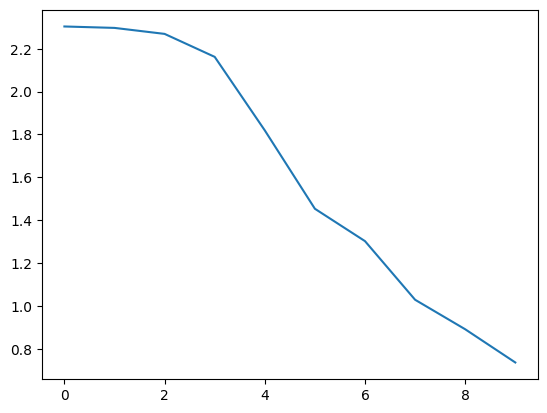

In [ ]:
plt.plot(loss_arr_SGD)
plt.show()

# **테스트 데이터셋을 통한 성능 평가**
# **SGD 옵티마이저 학습 모델의 정확도 측정**
 **테스트 데이터 정확도 측정 및 비교**

In [ ]:
# SGD 옵티마이저로 학습된 모델의 정확도 측정
accuracy_sgd = calculate_accuracy(model, device, test_loader)
print(f"Accuracy with SGD: {accuracy_sgd}%")

# 정확도 비교
if accuracy_adam > accuracy_sgd:
    print("Adam optimizer performs better on this test data.")
else:
    print("SGD optimizer performs better on this test data.")

Accuracy with SGD: 76.90304487179488%
Adam optimizer performs better on this test data.
